# Cross-checking Time Series Analysis: Forecasting industry performance

This report explores time series data, specifically stock prices. Stocks, or shares, refer to a financial instrument that reflects some degree of ownership in a company or organisation. These financial instruments provide liquidity for a company, while also giving some indication towards its performance in general. As these financial instruments have varying prices over time, there exist roles and professions that directly deal with the buying and selling of these stocks, such as investors and traders.

Stock trading is a well-known profession, and the prospect of being able to predict stock prices (and in so, exploiting it for monetary gain) is one coveted by professionals and amateurs alike. A myriad of "strategies" exist to predict stock prices, and these strategies range across varying factors, such as the duration of a strategy, or the underlying approach towards it. 

Qualitative methods such as evaluating a company's performance, mission or leadership structure tend to be long-term strategies, most of which are considered as investments. Quantitative methods exist as well, primarily used by hedge funds or market makers in an attempt to model, and predict, a stock price's movement mathematically. 

This report acknowledges that a rigorous attempt to predict stock price movements is mathematically overly complex, and thus will instead focus on general forecasting of the performance of an industry. This allows for the forgoing of highly accurate price predictions over a short time interval, while still maintaining accuracy over an industry's general trend.

The report will use Yahoo Finance's dataset as our main data, where we will perform the following:

1) Data Cleaning and Processing

2) Explanation of terminology

3) Exploratory data analysis

4) Modelling and Prediction

# Imports

We will be importing the standard libraries for data analysis, the libraries required for our data, as well as specific libraries to support time series analysis.

In [ ]:
# yfinance==0.2.38
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import norm

# Section 1: Data Preparation

We start our analysis by extracting our data from Yahoo Finance.
We will do so using the following steps:
1. Identify the stock tickers and idustries we wish to analyse
2. Extract only the data we need.

We will be using the opening and closing prices of each day from the last 10 years (01-01-2014 to 01-01-2024).
This data will be stored in a CSV named 'historical_stock_data_10yrs.csv' with the columns 'Date', 'Open', 'Close', 'Industry'.

In [ ]:
# Define the stock symbols and their corresponding industries
tickers = {
    'Technology/AI': ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'HPQ', 'DELL', 'IBM'],
    'Education': ['CHGG', 'LRN', 'GSX', 'EDU', 'TWOU'],
    'Airline': ['LUV', 'DAL', 'AAL', 'UAL', 'RYAAY'],
    'Semicon': ['INTC', 'TSM', 'ASML', 'QCOM', 'AMAT'],
    'Gold': ['NEM', 'GOLD', 'AUY', 'KGC', 'ABX'],
    'Oil': ['XOM', 'CVX', 'BP', 'TOT', 'RDS-A', 'SLB', 'COP', 'EOG'],
    'Auto': ['TSLA', 'GM', 'F', 'HMC', 'VWAGY'],
    'Pharma': ['JNJ', 'PFE', 'MRK', 'ABBV', 'GSK', 'BIO', 'GILD', 'AMGN'],
    'Consumer': ['PG', 'KO', 'PEP', 'NKE', 'UL', 'SONY', 'SSNLF', 'LNVGY'],
    'Financial': ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'PNC', 'USB'],
    'Retail': ['AMZN', 'WMT', 'COST', 'TGT', 'M', 'BBY', 'HD', 'LOW'],
    'Real Estate': ['AMT', 'SPG', 'WELL'],
    'Utilities': ['NEE', 'DUK', 'SO'],
    'Telecommunications': ['T', 'VZ', 'TMUS'],
    'Materials': ['LIN', 'ECL', 'APD'],
    'Industrials': ['GE', 'MMM', 'HON'],
    'Consumer Staples': ['WMT', 'COST', 'PG'],
    'Healthcare Services': ['UNH', 'CI', 'ANTM'],
    'Biotechnology': ['REGN', 'VRTX', 'ALXN'],
    'Entertainment': ['DIS', 'NFLX', 'CMCSA'],
    'Automotive Manufacturers': ['F', 'GM', 'TM']
}

# Combine all tickers into a single list
all_tickers = [ticker for sublist in tickers.values() for ticker in sublist]

# Fetch the historical data for each ticker
start_date = '2014-01-01'
end_date = '2024-01-01'
interval = '1d'
all_data = pd.DataFrame()

for industry, industry_tickers in tickers.items():
    for ticker in industry_tickers:
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval)[['Open', 'Close']]
        data.reset_index(inplace=True)
        data['Ticker'] = ticker
        data['Industry'] = industry
        all_data = pd.concat([all_data, data], ignore_index=True)

# Save the combined data to a CSV file
csv_file_path = 'historical_stock_data_10yrs.csv'
all_data.to_csv(csv_file_path, index=False)
print(f'Data saved to {csv_file_path}')

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_717/1622249356.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker
/tmp/ipykernel_717/1622249356.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Industry'] = industry
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_717/1622249356.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

# Data cleaning and processing

We import the extracted data, and do some simple processing. For convenience, we set Date into DateTime format.

In [ ]:
# Read the data from the CSV file
df = pd.read_csv('historical_stock_data_10yrs.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df)

                  Open       Close Ticker                  Industry
Date                                                               
2014-01-02   19.845715   19.754642   AAPL             Technology/AI
2014-01-03   19.745001   19.320715   AAPL             Technology/AI
2014-01-06   19.194643   19.426071   AAPL             Technology/AI
2014-01-07   19.440001   19.287144   AAPL             Technology/AI
2014-01-08   19.243214   19.409286   AAPL             Technology/AI
...                ...         ...    ...                       ...
2023-12-22  178.059998  178.529999     TM  Automotive Manufacturers
2023-12-26  178.529999  179.850006     TM  Automotive Manufacturers
2023-12-27  180.380005  180.720001     TM  Automotive Manufacturers
2023-12-28  181.020004  181.110001     TM  Automotive Manufacturers
2023-12-29  183.130005  183.380005     TM  Automotive Manufacturers

[240816 rows x 4 columns]


# Exploratory Data Analysis

## Prices

We can see a sample of a ticker, for example AAPL (Apple), like so. We simplify the price of the stock during the day as (Opening_price + Closing_price) / 2.

/tmp/ipykernel_717/1596307442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['Mid_Price'] = (aapl['Open'] + aapl['Close']) /2


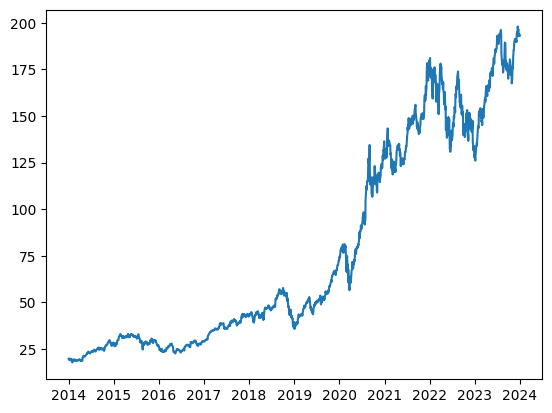

In [ ]:
aapl = df[df['Ticker'] == 'AAPL']
aapl['Mid_Price'] = (aapl['Open'] + aapl['Close']) /2
plt.plot(aapl['Mid_Price'])

We see a sharp rise in price, almost exponential in nature, from the year 2014 to 2024. This corresponds to Apple's growth as a company over the years, where we see Apple products start to take over the electronics and technology market.

We can also plot the distribution of its price, and find out the quantile information.

count    2516.000000
mean       77.888696
std        56.194906
min        17.781785
25%        29.768750
50%        48.042500
75%       134.646248
max       198.065002
Name: Mid_Price, dtype: float64


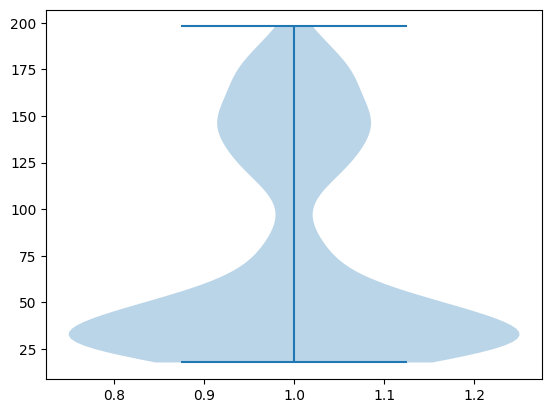

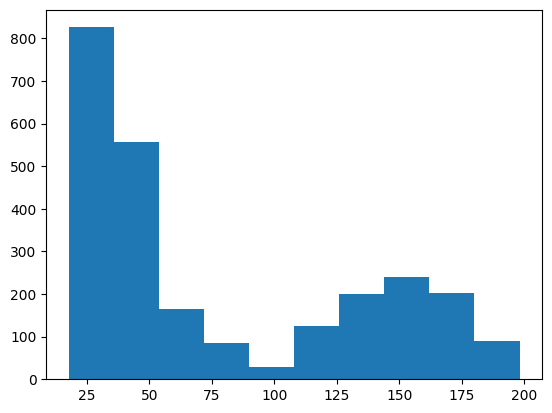

In [ ]:
print(aapl['Mid_Price'].describe())
plt.violinplot(aapl['Mid_Price'])
plt.show()
plt.hist(aapl['Mid_Price'])
plt.show()

We see that the price distribution is rather skewed and uneven, and it becomes difficult to further use this distribution to gain any insight. There is, however, a method we can use to feature engineer the price - using returns. 

## Returns

Returns is defined as the money made or lost in an investment, but can be calculated as such: Price_at_Time_X / Price_at_Time_Y, where X is a date later than Y. We can scale our returns down to a daily basis, like so:

/tmp/ipykernel_717/413399290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['Daily_Returns'] = aapl['Mid_Price'] / aapl['Mid_Price'].shift().fillna(starting_price)


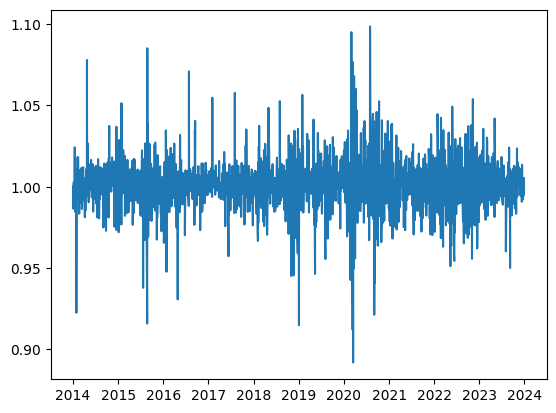

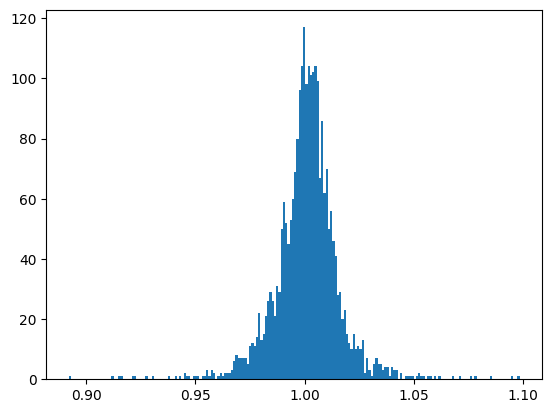

In [ ]:
# We know the price of AAPL is (19.845715 + 19.754642) / 2 on 2nd Jan 2014.
starting_price = (19.845715 + 19.754642) / 2
aapl['Daily_Returns'] = aapl['Mid_Price'] / aapl['Mid_Price'].shift().fillna(starting_price)
plt.plot(aapl['Daily_Returns'])
plt.show()
plt.hist(aapl['Daily_Returns'], bins = 200)
plt.show()

We see that the distribution of returns becomes a lot more like a normal distribution, albeit scaled, and we can further find the parameters for this distribution.

In [ ]:
print(aapl['Daily_Returns'].describe())
print(f"Mean of this dist is: {np.mean(aapl['Daily_Returns'])},  Variance is {np.var(aapl['Daily_Returns'])}, Standard Deviation is {np.sqrt(np.var(aapl['Daily_Returns']))}")

count    2516.000000
mean        1.001019
std         0.015032
min         0.891869
25%         0.994196
50%         1.001472
75%         1.008309
max         1.098580
Name: Daily_Returns, dtype: float64
Mean of this dist is: 1.0010190129430019,  Variance is 0.00022586342395117284, Standard Deviation is 0.015028753240078595


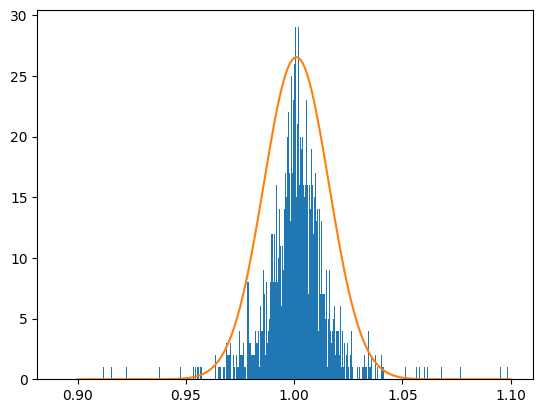

In [ ]:
# Comparing the plot with a Normal Distribution ~N(1.001019m 0.00022586)
plt.hist(aapl['Daily_Returns'], bins = 1000)

#x-axis ranges from -3 and 3 with .001 steps
x = np.arange(0.90, 1.1, 0.001)

#plot normal distribution with mean 0 and standard deviation 1
plt.plot(x, norm.pdf(x, np.mean(aapl['Daily_Returns']), np.sqrt(np.var(aapl['Daily_Returns']))))
plt.show()

We see that in general, returns tend to follow a much more normal distribution. For the purposes of this report, we will be measuring performance in terms of returns. The explanation for using a normal distribution and measuring performance in terms of returns will be given later below.

We will also only focus on industry-level performance, so we process our data and group them by industries. To simplify calculations and get better data analysis, we will also be using daily returns.

In [ ]:
# Calculate the daily return 
df['Daily_Returns'] = df['Close']/ df['Open']

# .resample("D") resamples values grouped by Indsutry to find daily returns using .mean()
df_daily = df[['Daily_Returns', 'Industry']].groupby('Industry').resample("D").mean()

# .resample("W") resamples values grouped by Indsutry to find weekly returns using .mean()
df_weekly = df[['Daily_Returns', 'Industry']].groupby('Industry').resample("W").mean()

# resampling for yearly returns
df_yearly = df[['Daily_Returns', 'Industry']].groupby('Industry').resample("Y").mean()


# Unstack the 'Industry' level to have industries as columns
df_daily = df_daily.unstack(level='Industry')['Daily_Returns']
df_weekly = df_weekly.unstack(level='Industry')['Daily_Returns']
df_yearly = df_yearly.unstack(level='Industry')['Daily_Returns']

Airline industry:


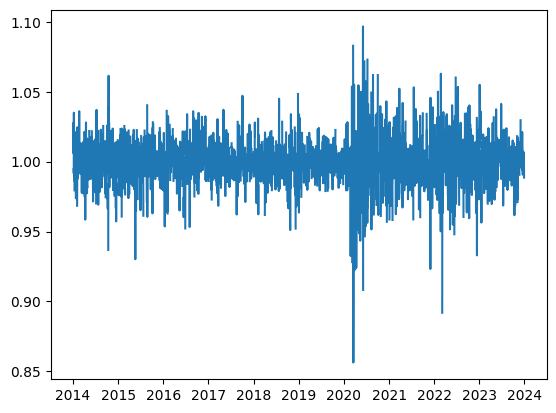

Auto industry:


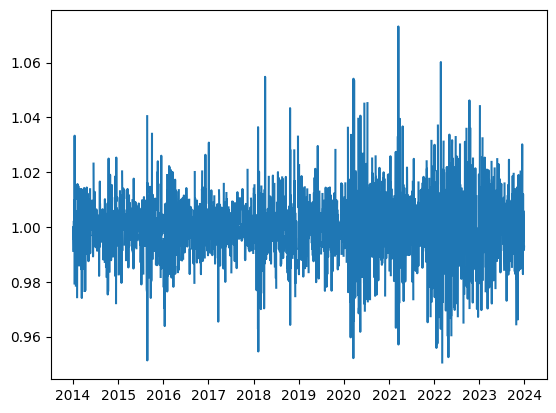

Technology/AI industry:


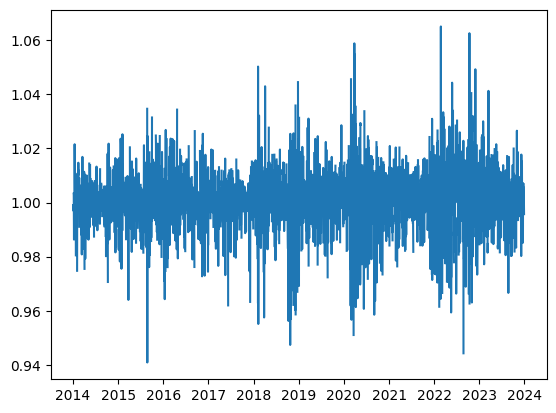

Entertainment industry:


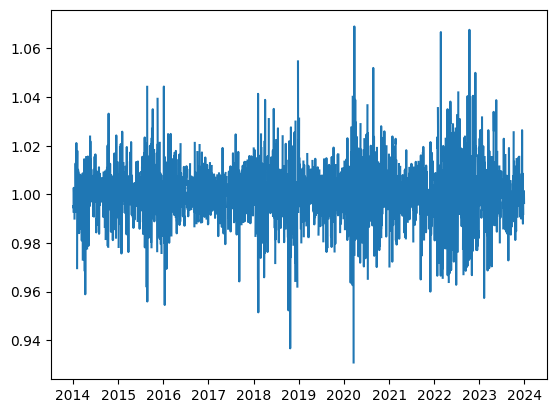

In [ ]:
for ind in ["Airline", "Auto", "Technology/AI", "Entertainment"]:
    print(f"{ind} industry:")
    plt.plot(df_daily[ind])
    plt.show()

We see that the daily returns tend to lie somewhere around 1, but come close to 2020, we see a sudden spike in multiple industries, particularly Airline. This is highly attributed to the COVID-19 pandemic. We can observe the quantitative effects of this as the plunge in returns. The variations in these spikes can be analysed as the volatility of the industry, which will be analyse in the next segment.

## Volatility

Volatility is defined as the dispersion of returns for a financial instrument.

We can mathematically measure volatility by calculating the standard deviation of the returns of an industry over a year. With this, if a stock trades in a narrow trading range, the standard deviation would return a lower value, which corresponds to a lower volatility. Since the returns tend to be rather stable, we can aggregate them for simpler calculations by looking at weekly returns for an industry.

In [ ]:
df_weekly

Industry,Airline,Auto,Automotive Manufacturers,Biotechnology,Consumer,Consumer Staples,Education,Entertainment,Financial,Gold,...,Industrials,Materials,Oil,Pharma,Real Estate,Retail,Semicon,Technology/AI,Telecommunications,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-05,1.016935,0.995589,0.993712,0.993706,0.995713,0.995245,0.989393,0.994930,1.005855,1.003226,...,0.996680,0.999495,0.994087,0.998905,1.002768,0.999293,0.995005,0.998113,0.994619,0.992157
2014-01-12,1.010525,0.996539,0.996193,1.004595,1.000291,0.997369,0.998139,0.997546,0.998959,0.999146,...,0.995275,1.000802,0.998498,1.000050,1.004275,0.996986,0.998570,0.997177,0.996697,1.002600
2014-01-19,0.999600,1.002954,0.997110,1.013521,0.997972,0.998578,0.997008,0.997759,0.999085,1.005593,...,0.999511,1.001376,0.997727,1.001391,1.000981,0.995991,1.003204,1.004041,0.996575,0.999528
2014-01-26,0.994909,0.996195,0.993149,0.993342,0.997097,0.994774,0.986979,1.000205,0.991743,0.996749,...,0.989572,0.990601,0.994677,0.996399,0.995390,0.996857,0.997153,0.992752,0.996271,1.001943
2014-02-02,1.002777,0.999040,0.994206,1.001705,0.998186,0.998831,0.992763,1.006872,1.000605,0.995549,...,1.001334,1.000364,0.998770,1.000047,1.004752,0.997511,0.998474,1.000754,1.002594,1.007116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,1.006207,1.001846,1.001698,0.999406,1.001889,1.000642,0.993496,0.994631,1.008834,1.014148,...,1.004557,1.001259,0.996896,1.002879,1.007175,1.006411,1.000378,1.000667,1.006023,1.003558
2023-12-10,1.007851,1.003801,1.003448,1.004717,0.999257,0.998333,0.998150,0.999099,1.003500,0.997369,...,1.001218,0.996570,0.993880,1.000232,1.002019,1.003104,1.000620,1.001877,1.000698,1.002074
2023-12-17,1.007974,1.008470,1.009144,1.012875,1.002922,1.003437,1.005236,1.003913,1.013710,1.010090,...,1.003728,1.005634,1.006994,1.001445,1.008314,1.004855,1.009840,1.005022,0.997836,1.004279


Using the weekly returns, we can find the volatility here.

Consumer Volatility: 0.0060540527075494555
Consumer Staples Volatility: 0.008434463425096858
Pharma Volatility: 0.008463826518586237
Telecommunications Volatility: 0.009107811614788163
Materials Volatility: 0.01006183486367136
Retail Volatility: 0.010431188415901566
Utilities Volatility: 0.010619639060846287
Industrials Volatility: 0.010914776683274731
Automotive Manufacturers Volatility: 0.01186696541524729
Entertainment Volatility: 0.012171473080515575
Auto Volatility: 0.012205396266941273
Financial Volatility: 0.01226926084972888
Technology/AI Volatility: 0.012272490507132779
Real Estate Volatility: 0.01235775538659804
Healthcare Services Volatility: 0.012983590133948498
Semicon Volatility: 0.013032118871668013
Oil Volatility: 0.013834323250354488
Biotechnology Volatility: 0.016286679798131587
Airline Volatility: 0.0174017028769832
Education Volatility: 0.01946497703992188
Gold Volatility: 0.021024380541499136


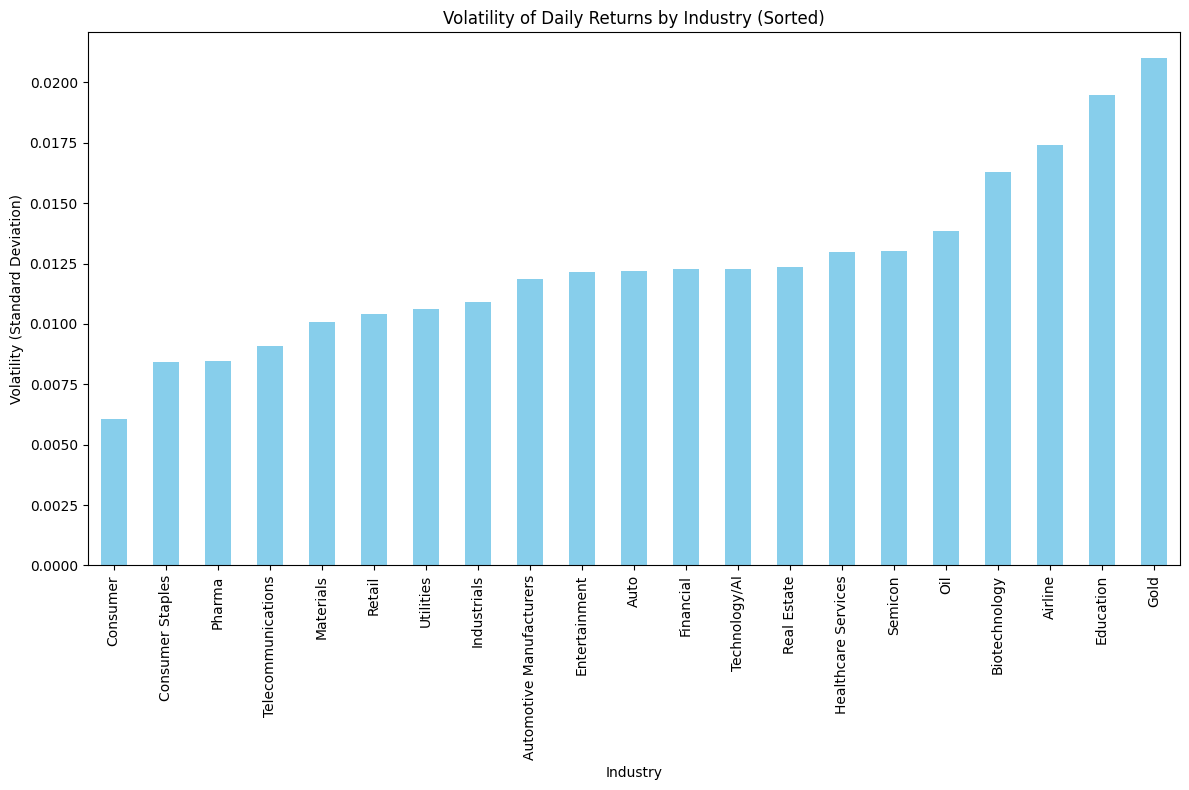

In [ ]:
# Calculate volatility (standard deviation of returns)
volatility = df_daily.std()

# Sort the volatilities
sorted_volatility = volatility.sort_values()

# Print each industry's volatility in sorted order
for industry in sorted_volatility.index:
    print(f"{industry} Volatility: {sorted_volatility[industry]}")

# Plotting
plt.figure(figsize=(12, 8))
sorted_volatility.plot(kind='bar', color='skyblue')
plt.title('Volatility of Daily Returns by Industry (Sorted)')
plt.xlabel('Industry')
plt.ylabel('Volatility (Standard Deviation)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Cross checking the volatility as the standard deviation, we can make a plot of the returns of the Oil Industry as an example. We see the volatility is 0.013834323250354488.

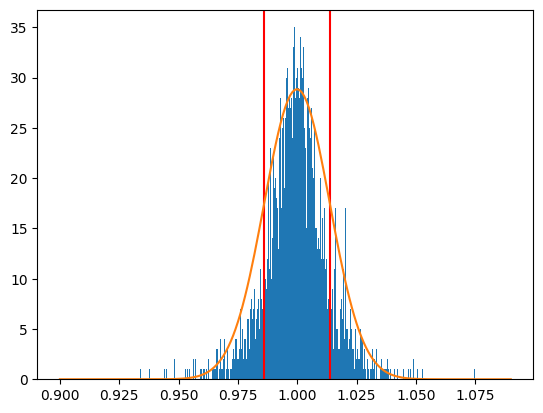

In [ ]:
oil_returns = df_daily['Oil']
plt.hist(oil_returns, bins = 500)
# the standard deviation is given as volatility
plt.axvline(x = 1 + 0.013834323250354488, color = 'r', label = 'axvline - full height')
plt.axvline(x = 1 - 0.013834323250354488, color = 'r', label = 'axvline - full height')

# we can also input the standard deviation into a normal distribution and find that the normal distribution looks very similar
x = np.arange(0.90, 1.09, 0.001)
plt.plot(x, norm.pdf(x, np.mean(oil_returns), np.sqrt(np.var(oil_returns))))
plt.show()
plt.show()

### Conclusions:

From initial analysis, we are able to visually see that the volatility of each industry fluctuates steadily about the 0.0 value and staying in the rang of +-0.05 typically. This is with exceptions in 2020, which is suspected to be due to the COVID-19 pandemic. During this time, most industries faced a huge spike in volatility, with the exception of industries like Gold, Biotechnology and Entertainment, whose volatility did not see unusual spikes, possibly due to the high volatility of its volatility in normal times.

# Augmented Dickey–Fuller test (ADF)

The reason why we chose to do our data analysis on returns instead of prices was due to its stationarity. Stationarity refers to a time series data's tendency to not have trends or seasonality. This would also mean having a constant mean and standard deviation. Non-stationary data in this case would be akin to the price movement for AAPL stock - we see a clear rise in prices over time. Stationary data would be like the returns for AAPL, where we do not see a clear trend in the movement of that data. Stationarity is a key assumption for time-series-based linear regression, and to eventually develop a model capable of encapsulating the movement of a stock's price, we need to ensure that we fit the model on a stationary feature of the stock data.

Non-stationary data, on the other hand, can lead to unreliable model outputs and inaccurate predictions. Therefore, stationarity is important for 
#### Easier modeling and forecasting. 
Stationarity simplifies the complexities within time series data, making it easier to model and forecast than non-stationary time series. The stationarity of a time series data can be attributed to the existence of a unit root. 

The Augmented Dickey-Fuller test tests the null hypothesis, H0, that the data has a unit root (or the data is non-stationary). If the test statistic (printed as 'ADF Statistic') is more negative than the critical value (p-value), we can confidently reject the null hypothesis and conclude that the time series is stationary.

##### H0:

In [ ]:
# Function to perform ADF test and print results for log, first difference, and second difference
def adf_test_transformations(industry_name, timeseries):
    # Applying log transformation and handling zero or negative values
    timeseries = timeseries[timeseries > 0]  # Filter out non-positive values
    log_timeseries = np.log(timeseries)
    
    # First difference of the log-transformed time series
    log_timeseries_diff = log_timeseries.diff().dropna()
    
    # Second difference of the log-transformed time series
    log_timeseries_diff2 = log_timeseries.diff().diff().dropna()
    
    print(f'\nRunning ADF test on {industry_name}')
    
    # Original log prices
    result_log = adfuller(log_timeseries.dropna(), autolag='AIC')
    print(f'ADF Statistic (Log Prices): {result_log[0]}')
    print(f'p-value (Log Prices): {result_log[1]}')
    
    # First difference
    result_diff1 = adfuller(log_timeseries_diff, autolag='AIC')
    print(f'ADF Statistic (1st Log Difference): {result_diff1[0]}')
    print(f'p-value (1st Log Difference): {result_diff1[1]}')
    
    # Second difference
    result_diff2 = adfuller(log_timeseries_diff2, autolag='AIC')
    print(f'ADF Statistic (2nd Log Difference): {result_diff2[0]}')
    print(f'p-value (2nd Log Difference): {result_diff2[1]}')

In [ ]:
# Run ADF test with log and differencing transformations for each industry
for industry in df_weekly.columns:
    industry_data = df_weekly[industry].replace([np.inf, -np.inf], np.nan).dropna()  # Handle infinite values if any
    if not industry_data.empty:
        adf_test_transformations(industry, industry_data)


Running ADF test on Airline
ADF Statistic (Log Prices): -19.951091763965096
p-value (Log Prices): 0.0
ADF Statistic (1st Log Difference): -10.607827066447298
p-value (1st Log Difference): 5.939388972760284e-19
ADF Statistic (2nd Log Difference): -10.896857773861155
p-value (2nd Log Difference): 1.1861974787487676e-19

Running ADF test on Auto
ADF Statistic (Log Prices): -23.570243021156845
p-value (Log Prices): 0.0
ADF Statistic (1st Log Difference): -11.354018655861587
p-value (1st Log Difference): 9.835383462781507e-21
ADF Statistic (2nd Log Difference): -10.892959725133204
p-value (2nd Log Difference): 1.2120348061805587e-19

Running ADF test on Automotive Manufacturers
ADF Statistic (Log Prices): -15.488150306210871
p-value (Log Prices): 2.5050750437327888e-28
ADF Statistic (1st Log Difference): -10.045639639939061
p-value (1st Log Difference): 1.4569574544276988e-17
ADF Statistic (2nd Log Difference): -10.77119942024669
p-value (2nd Log Difference): 2.3818309463347205e-19

Runnin

### Conclusion:
Based on the ADF tests, all industries have a ADF statistic more negative than the p-value. Therefore, over the 10 years, returns on these industries were all stationary. Meaning these industries move and grow in a predicable fashion, making it worthwhile to investigate its correlations for our purposes.

# Section 2.1: Correlations

We will examine 2 main types of correlations:
1. Cross-correlation: The correlation between 2 industries. We will measure this using the cross-correlation function.
2. Self-correlation: The correlation between prices at different times and different time lags. We will measure this using the auto-correlation function and partial auto-correlation functions.

## Cross-Correlation Function (CCF): 

This function tracks the movements of two or more sets of time series data relative to one another. We use this to derive a conclusion on which industries are correlated. The correlations of 2 industries are calculated with varying lags (within the range of +-max_lag).

We will calculate all possible combinations of industries and plot the graphs of the industries with the top 5 highest cross-correlation values.

In [ ]:
# Define the maximum number of lags
max_lag = 52
industry_pairs = list(combinations(df_weekly.columns, 2))
results = []

for industry1, industry2 in industry_pairs:
    lags = np.arange(-max_lag, max_lag + 1)
    cross_corr = [df_weekly[industry1].corr(df_weekly[industry2].shift(lag)) for lag in lags]
    lag_max_corr = lags[np.argmax(cross_corr)]

    # Store results with additional details for plotting
    results.append({
        'Industry1': industry1,
        'Industry2': industry2,
        'Max CCF': max(cross_corr),
        'Lag': lag_max_corr,
        'Cross_Corr': cross_corr,
        'Lags': lags
    })

# Sort results by 'Max CCF' in descending order and get the top 20
top_results = sorted(results, key=lambda x: x['Max CCF'], reverse=True)[:20]

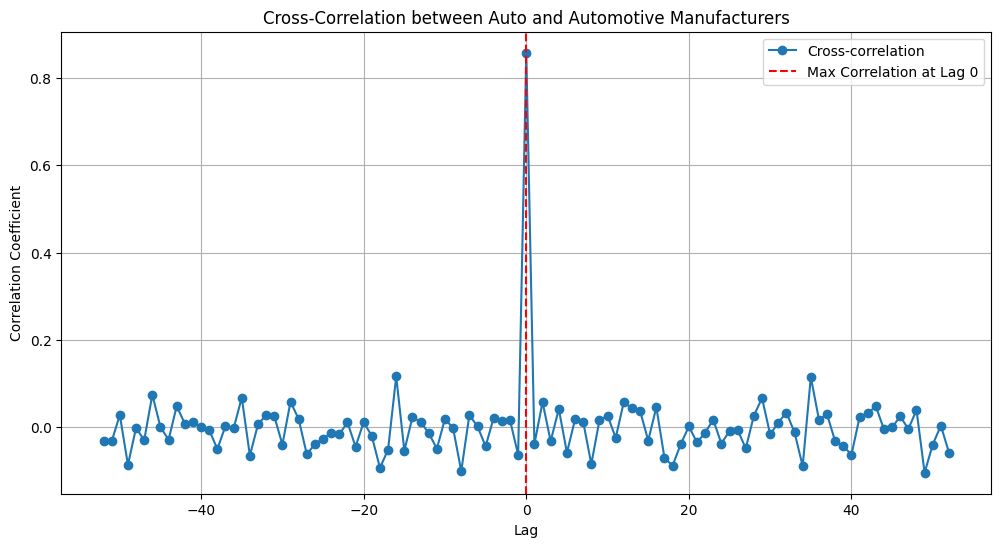

Auto vs Automotive Manufacturers - Max CCF: 0.858 at Lag: 0


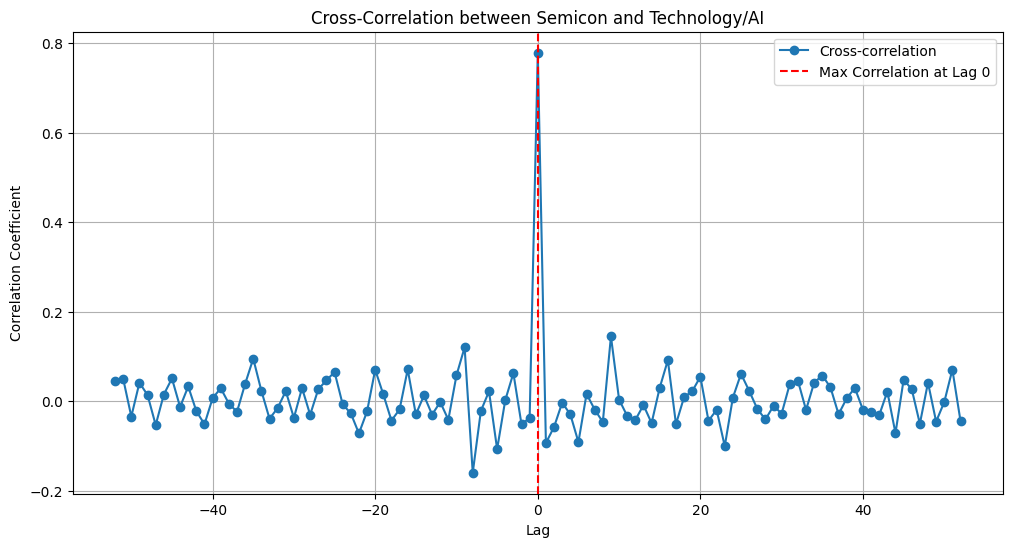

Semicon vs Technology/AI - Max CCF: 0.779 at Lag: 0


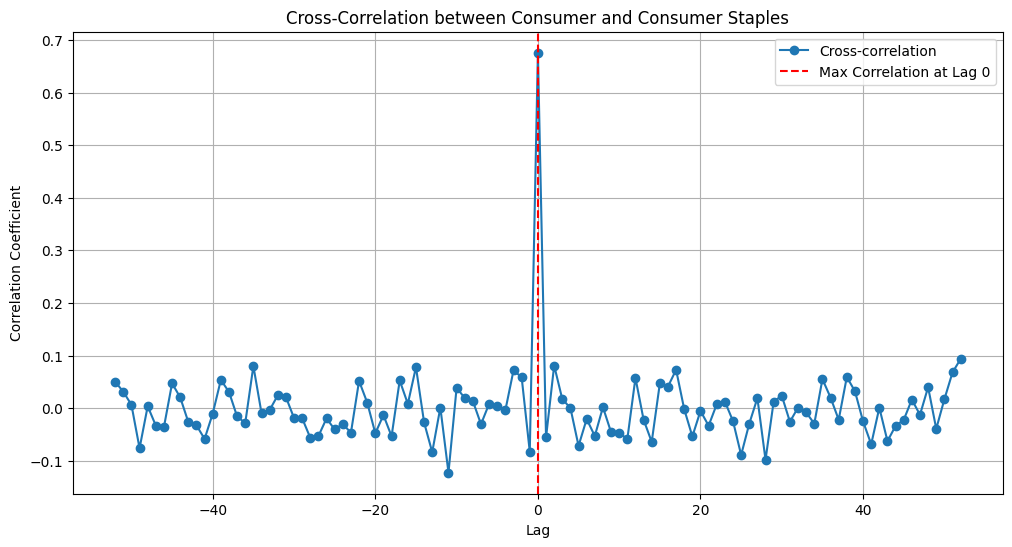

Consumer vs Consumer Staples - Max CCF: 0.676 at Lag: 0


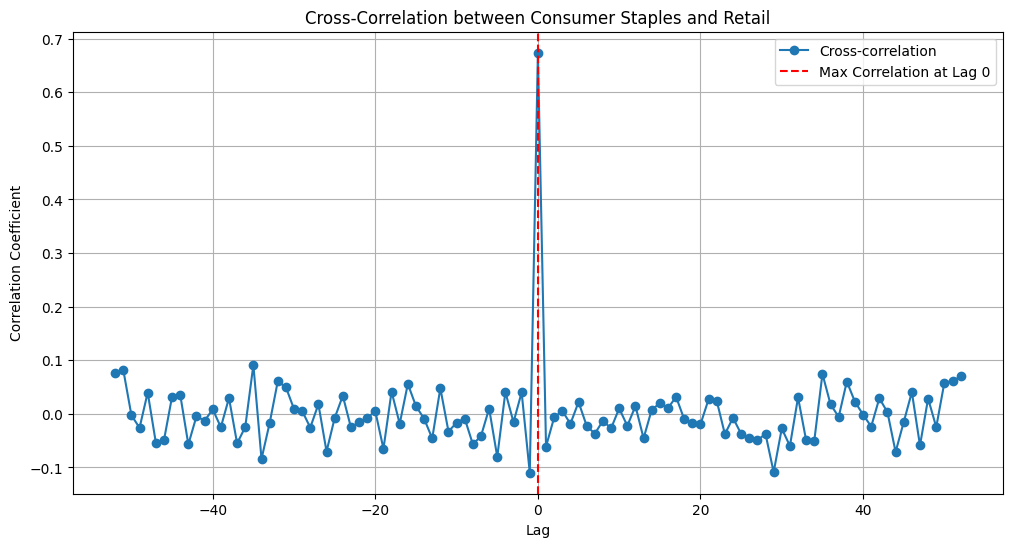

Consumer Staples vs Retail - Max CCF: 0.674 at Lag: 0


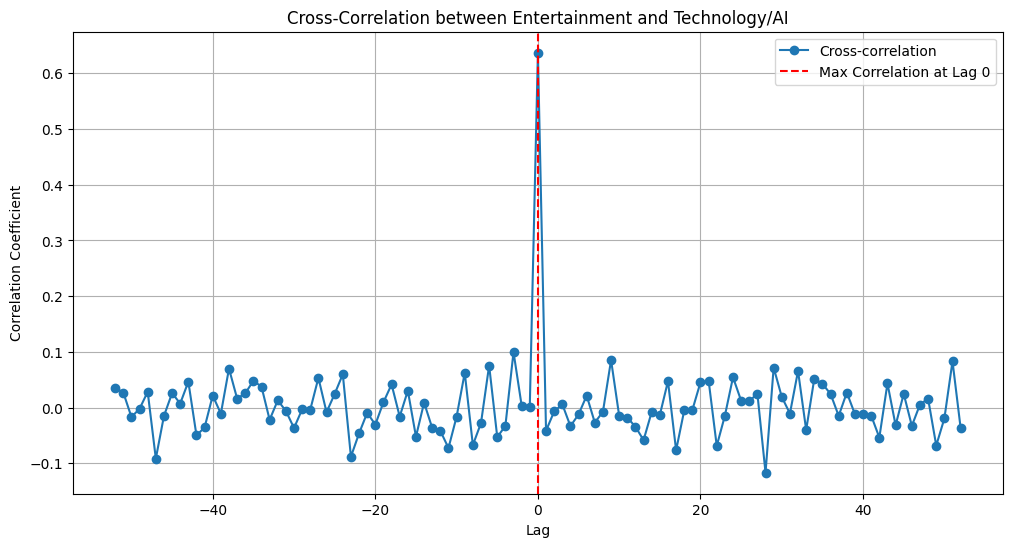

Entertainment vs Technology/AI - Max CCF: 0.637 at Lag: 0
Financial vs Industrials - Max CCF: 0.631 at Lag: 0
Retail vs Technology/AI - Max CCF: 0.627 at Lag: 0
Auto vs Technology/AI - Max CCF: 0.621 at Lag: 0
Consumer vs Retail - Max CCF: 0.606 at Lag: 0
Auto vs Semicon - Max CCF: 0.602 at Lag: 0
Auto vs Retail - Max CCF: 0.601 at Lag: 0
Automotive Manufacturers vs Financial - Max CCF: 0.594 at Lag: 0
Airline vs Automotive Manufacturers - Max CCF: 0.593 at Lag: 0
Biotechnology vs Pharma - Max CCF: 0.593 at Lag: 0
Automotive Manufacturers vs Industrials - Max CCF: 0.591 at Lag: 0
Consumer vs Technology/AI - Max CCF: 0.589 at Lag: 0
Consumer vs Materials - Max CCF: 0.581 at Lag: 0
Financial vs Retail - Max CCF: 0.569 at Lag: 0
Entertainment vs Retail - Max CCF: 0.569 at Lag: 0
Real Estate vs Utilities - Max CCF: 0.565 at Lag: 0


In [ ]:
# Plot the top 5 results, show the coeff for top 20
for idx in range(len(top_results)):
    result = top_results[idx]
    if idx < 5:
        plt.figure(figsize=(12, 6))
        plt.plot(result['Lags'], result['Cross_Corr'], marker='o', label='Cross-correlation')
        # Corrected the use of f-string below by adding parentheses
        plt.axvline(x=result['Lag'], color='red', linestyle='--', label=f"Max Correlation at Lag {result['Lag']}")
        # Corrected the use of f-string below by adding parentheses
        plt.title(f"Cross-Correlation between {result['Industry1']} and {result['Industry2']}")
        plt.xlabel('Lag')
        plt.ylabel('Correlation Coefficient')
        plt.legend()
        plt.grid(True)
        plt.show()
    # Print results, also corrected the use of f-string
    print(f"{result['Industry1']} vs {result['Industry2']} - Max CCF: {result['Max CCF']:.3f} at Lag: {result['Lag']}")

### Observations:
These top 20 correlations have values > 0.5, at their respective lag (which mostly tend to be at lag 0)

# Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF):

An ACF measures and plots the average correlation between data points in time series and previous values of the series measured for different lag lengths. PACF is similar to ACF except each partial correlation controls for any correlation between observations of a shorter lag length, this gives the correlation between the 2 ignoring the influence of correlations and intermediate lags. This helps to identify the direct relationships at specific lags without being confounded by correlations at other lags.

It should be noted that the ACF for any time lag d corresponds to the Pearson's Correlation Coefficient between X at time t and t-d.

##### These values are valuable for constructing our linear regression ARIMA models later.

##### The ACF equation:

<img src="image-20240424-143926.png" width="" align="" />

<Figure size 1000x400 with 0 Axes>

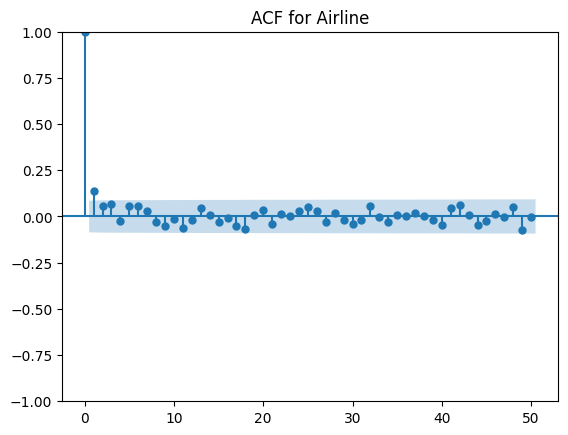

<Figure size 1000x400 with 0 Axes>

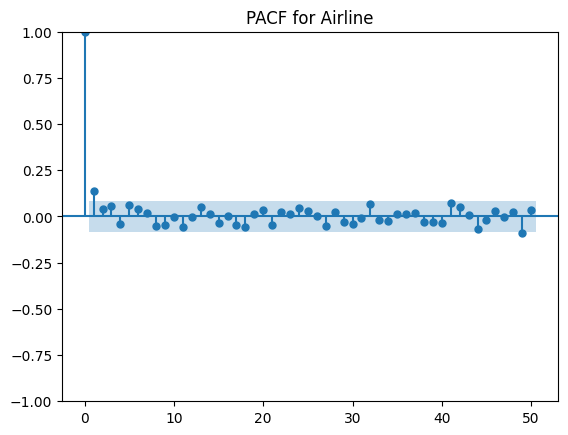

<Figure size 1000x400 with 0 Axes>

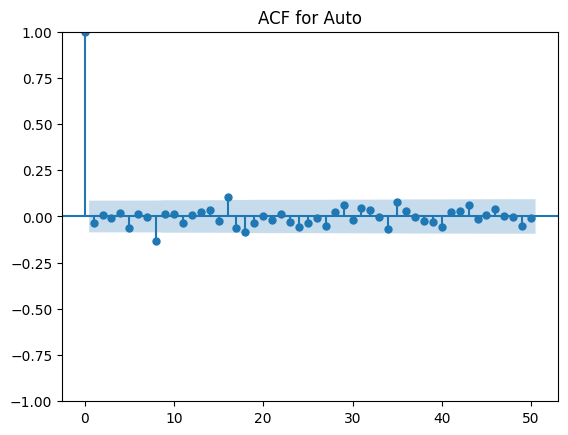

<Figure size 1000x400 with 0 Axes>

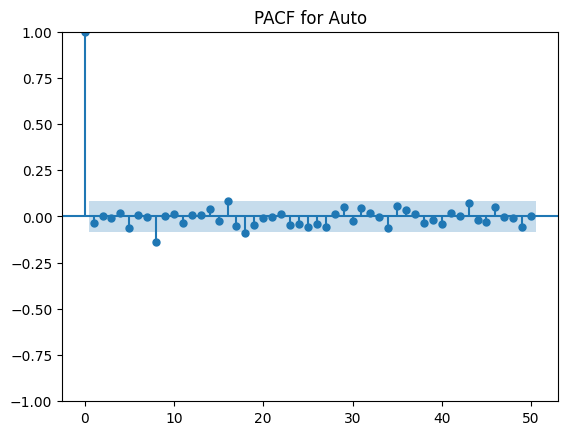

<Figure size 1000x400 with 0 Axes>

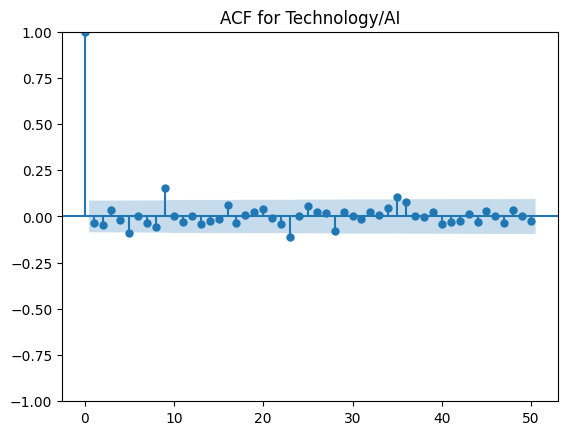

<Figure size 1000x400 with 0 Axes>

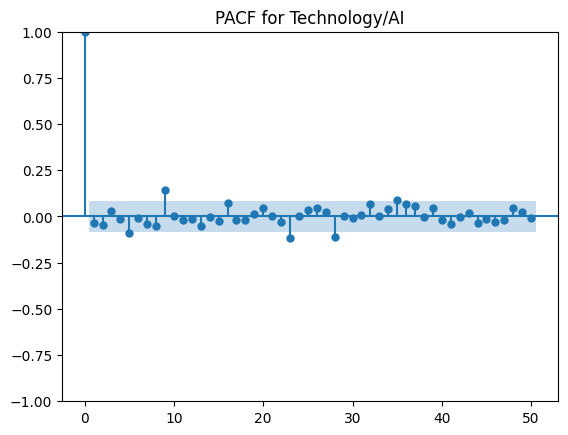

<Figure size 1000x400 with 0 Axes>

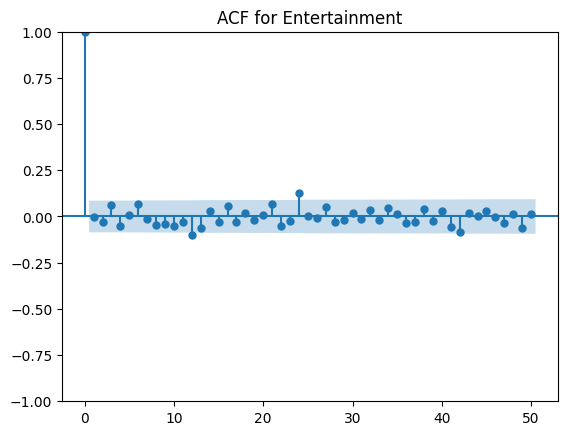

<Figure size 1000x400 with 0 Axes>

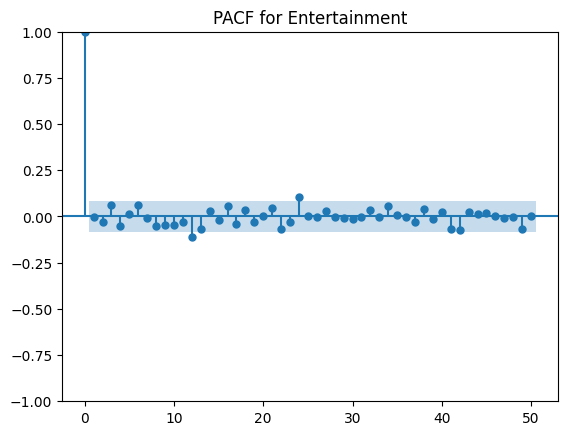

In [ ]:
# Plot ACF and PACF for each industry
industries = ["Airline", "Auto", "Technology/AI", "Entertainment"]
for industry in industries:
    
    plt.figure(figsize=(10, 4))
    plot_acf(df_weekly[industry].dropna(), title=f'ACF for {industry}', lags=50)
    plt.show()

    plt.figure(figsize=(10, 4))
    plot_pacf(df_weekly[industry].dropna(), title=f'PACF for {industry}', lags=50)
    plt.show()

# Modelling

## Auto-Regressive Model

### Weekly Returns

We can first attempt to use the information from the ACF and PACF plots to attempt to model industries using a linear regression. Specifically, the models we will be exploring are using Autoregressive models (ARMA). The key concept behind these models are the same as a linear regression: We assume the prices of a stock is dependent on its previous prices, and model the current returns of a stock by its previous values. The equation is given as below:

X(t) = b0 + b1 * X(t-1) + b2 * X(t-2) ... + bn * X(t-n) + e

where X(t) is the returns of an industry,

bi where i >= 0 are the intercepts and coefficients for previous terms X(t-k) where k >= 1,

and e is the error of the model.

This model makes some key assumptions:

1) The time series input variable is stationary, and the statistical properties like mean and variance are constant over time. We have ensured this by wrangling our prices into returns, which we have shown is stationary (it follows a distribution with a clear mean and standard deviation). These returns follow a clear, consistent distribution, making it ideal for modelling.

2) The errors are considered to be white noise, and also have constant mean and variance. This also means we must assume no external influence towards the pricing of a stock.

We can import the model as below. We will be attempting to model the movement of the Technology/AI industry, using up to the previous 10 price points.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df_weekly['Technology/AI'], order=(10,0,0))
model_fit = model.fit()

/root/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We can view the results here.

In [ ]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Technology/AI   No. Observations:                  522
Model:                ARIMA(10, 0, 0)   Log Likelihood                2031.951
Date:                Wed, 24 Apr 2024   AIC                          -4039.902
Time:                        08:20:51   BIC                          -3988.810
Sample:                    01-05-2014   HQIC                         -4019.890
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0006      0.000   4852.314      0.000       1.000       1.001
ar.L1         -0.0274      0.037     -0.749      0.454      -0.099       0.044
ar.L2         -0.0443      0.040     -1.105      0.2

We can find the MSE for our model, and cross-examine our errors to see if they fit a clear distribution.

MSE is 2.434414955918497e-05


<AxesSubplot: title={'center': 'Distribution for residuals (Errors)'}, ylabel='Density'>

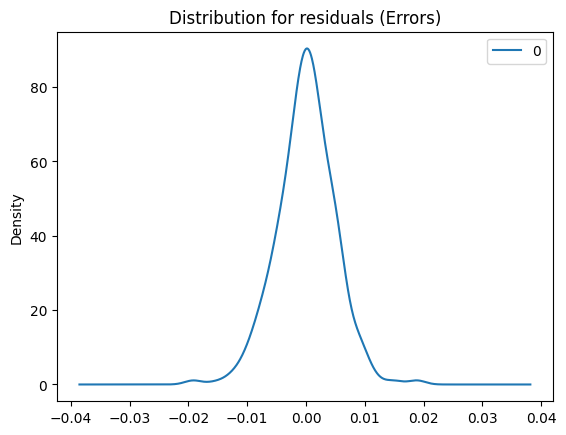

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
mse = np.mean(residuals**2)
print(f"MSE is {mse}")
residuals.plot(kind='kde', title='Distribution for residuals (Errors)')

We see that the errors follow a rather clear distribution, and thus can conclude that the errors are likely white noise.

We check the predicted values for model as such. We will see the general trend, as well as a subset of the returns movement in a time-frame. For example, 2020 January to June.

Text(0.5, 1.0, 'Actual Weekly Returns (2020 Jan-Jun)')

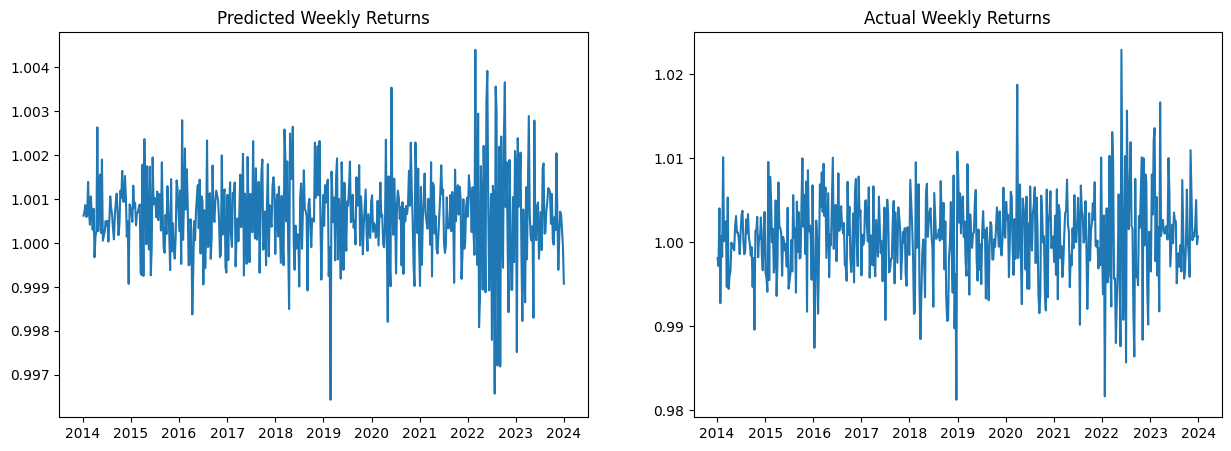

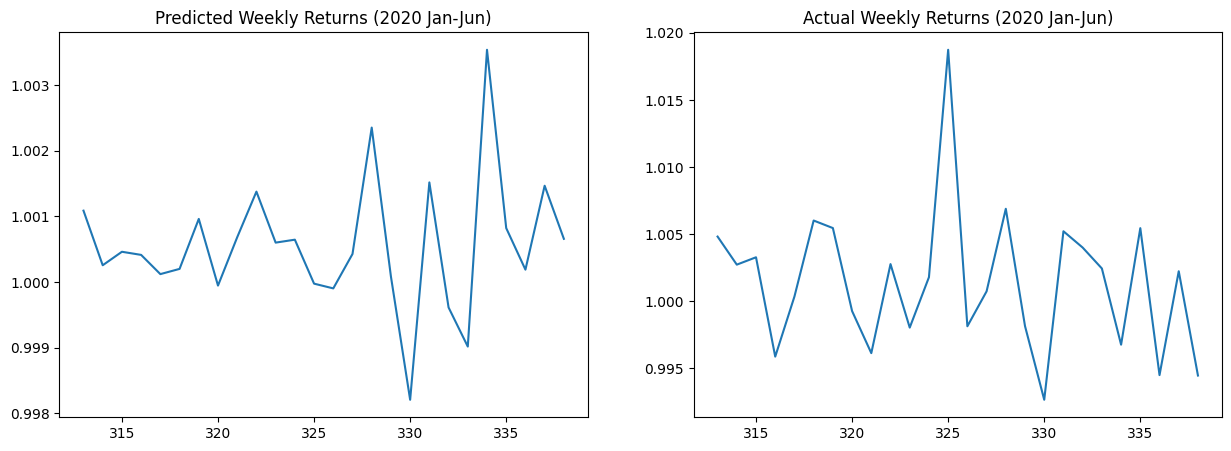

In [ ]:
# General trend over 10 years
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pred = model_fit.predict()
plt.subplot(1, 2, 1)
plt.plot(pred)
plt.title("Predicted Weekly Returns")
plt.subplot(1, 2, 2)
plt.plot(df_weekly['Technology/AI'])
plt.title("Actual Weekly Returns")

# Close up of 2020 Jan to June
techAI_returns = df_weekly['Technology/AI'].reset_index()
#start_date = pd.Timestamp(year = 2020, month = 1, day = 1)
#end_date = pd.Timestamp(year = 2020, month = 6, day = 1)
start_date = '2020-01-01'
end_date = '2020-06-30'


techAI_returns['pred'] = pred.to_frame().reset_index()['predicted_mean'] #reset_index sets our predicted values as "predicted_mean"
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(techAI_returns['pred'][(techAI_returns['Date'] >= start_date) & (techAI_returns['Date'] <= end_date)])
plt.title("Predicted Weekly Returns (2020 Jan-Jun)")
plt.subplot(1, 2, 2)
plt.plot(techAI_returns['Technology/AI'][(techAI_returns['Date'] >= start_date) & (techAI_returns['Date'] <= end_date)])
plt.title("Actual Weekly Returns (2020 Jan-Jun)")

It seems that our model is able to capture some of the key features of the returns movement over time. Specifically, it managed to capture the dip in returns in 2019 and 2022. However, we see that the predicted values when seen close up, is vastly different. In fact, we notice that the values predicted by our AR model tends to revolve very closely around 1.

Checking the coefficients for our model, we notice that the coefficients for the terms prior to the current price is <0.1, giving negligible effect to our results compared to the constant intercept 1.0005. The AR model finds that the best way to plot the regression equation is by giving each term almost 0 weight.

### Yearly Returns

We attempt the same on yearly returns. Because we only have a timeframe of 10 years, we arbitrarily choose a time lag of 2 years to model the yearly returns. We see that our coefficients here are much more significant, and our MSE is much lower.

In [ ]:
yearly_model = ARIMA(df_yearly['Technology/AI'], order=(2,0,0))
yearly_model_fit = yearly_model.fit()
print(yearly_model_fit.summary())
yearly_residuals = pd.DataFrame(yearly_model_fit.resid)
yearly_mse = np.mean(yearly_residuals**2)
print(f"MSE is {yearly_mse}")

                               SARIMAX Results                                
Dep. Variable:          Technology/AI   No. Observations:                   10
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  60.855
Date:                Wed, 24 Apr 2024   AIC                           -113.709
Time:                        09:35:33   BIC                           -112.499
Sample:                    12-31-2014   HQIC                          -115.037
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0006      0.000   7523.862      0.000       1.000       1.001
ar.L1         -0.3817      0.495     -0.771      0.441      -1.352       0.589
ar.L2         -0.6920      0.351     -1.972      0.0

We attempt to use the model to forecast yearly from 2014 to 2024. We see a significant improvement in the ability of the model to predict performance, the model is 

1) No longer solely returning a near constant value, and

2) The model is able to grasp at the general trends of the yearly returns.

Our reasoning for this is that on a shorter timeframe, the price of stocks tend to be heavily influenced by external events, which is naturally unpredictable in an enclosed environment containing on stock prices. However, as we take the yearly returns, we smoothen out the effect of these unpredictable events, which creates a more ideal data to model.

Text(0.5, 1.0, 'True Values')

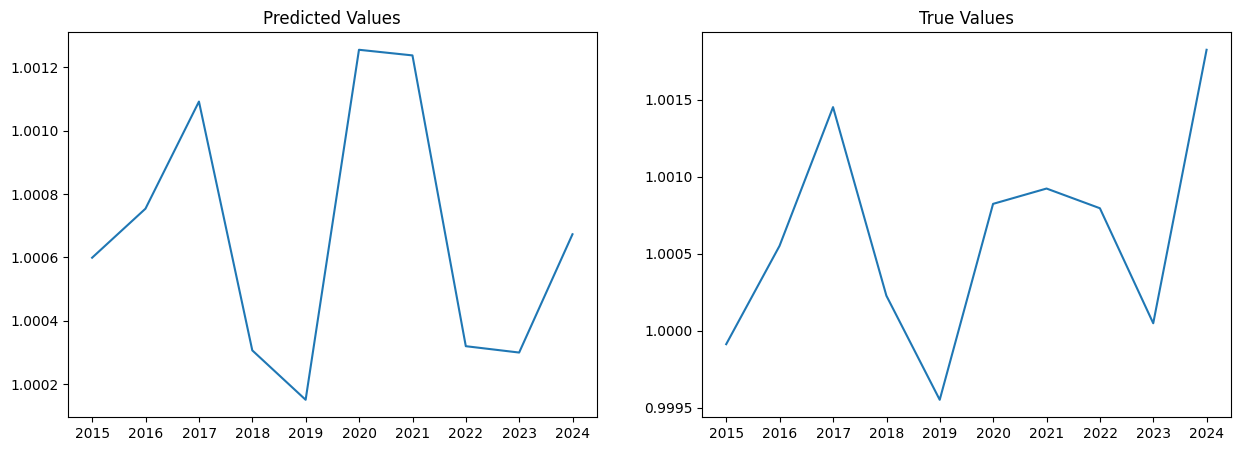

In [ ]:
pred = yearly_model_fit.predict()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pred)
plt.title('Predicted Values')
plt.subplot(1, 2, 2)
plt.plot(df_yearly['Technology/AI'])
plt.title('True Values')

## Linear Regression

### Weekly Returns

Recall that we have attempted to calculate and identify correlation coefficients across different industries from our Cross-Correlation Function (CCF). We now attempt to improve upon our model by including the past effect of industries that are well-correlated with our target industry, in this case "Technology/AI". The industries we will be using will be "Semicon" and "Auto" at lags (-8, -9), and (-8) respectively. These values are obtained from the time lags with the most significant correlation values from our CCF. The linear regression equation will thus be in the form:

T(t) =  a * T(t-1) + b * T(t-2) + c * S(t-8) + c * S(t-9) + d * A(t-8)

Where T refers to the returns of the Technology and AI industry, S the returns of the Semiconductor industry and A the returns of the Auto industry, and t referring to the week in question.

In [ ]:
# Isolating the required data, shift(x) shifts down the rows in a dataframe by the input amount x
tech_one_lag = df_weekly['Technology/AI'].shift(1).fillna(1).reset_index()
tech_two_lag = df_weekly['Technology/AI'].shift(2).fillna(1).reset_index()
semi_eight_lag = df_weekly['Semicon'].shift(8).fillna(1).reset_index()
semi_nine_lag = df_weekly['Semicon'].shift(9).fillna(1).reset_index()
auto_eight_lag = df_weekly['Auto'].shift(8).fillna(1).reset_index()
predictors = tech_one_lag
predictors = predictors.rename(columns = {"Technology/AI":"T1",})
predictors['T2'] = tech_two_lag['Technology/AI']
predictors['S8'] = semi_eight_lag['Semicon']
predictors['S9'] = semi_nine_lag['Semicon']
predictors['A8'] = auto_eight_lag['Auto']
#print(predictors)
# Importing our required library
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(predictors.drop(columns = "Date"), df_weekly['Technology/AI'].reset_index().drop(columns='Date'))
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

Coefficient: [[-0.0254973  -0.04028703 -0.08574095  0.09476859 -0.09785641]]
Intercept: [1.15526011]


We see the results here, as well as the MSE.

MSE is 2.4162206673121427e-05


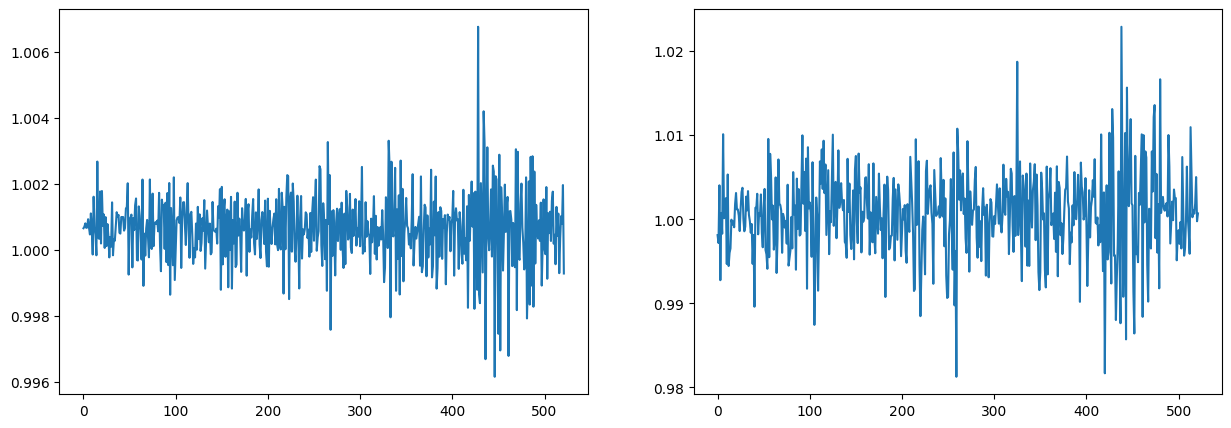

In [ ]:
pred = regressor.predict(predictors.drop(columns = "Date"))
true = df_weekly['Technology/AI'].reset_index().drop(columns='Date')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pred)
plt.subplot(1, 2, 2)
plt.plot(true)
LR_MSE = np.mean((pred-true) ** 2)
print(f"MSE is {LR_MSE}")

However, we also realise that the significance of the coefficients are also almost 0, similar the AR model on Technology and AI's returns alone. We also reattempt to forecast yearly returns. We arbitrarily take 1 year time lag for "Semicon" and "Auto". We see better results.

In [ ]:
tech_one_year_lag = df_yearly['Technology/AI'].shift(1).fillna(1).reset_index()
tech_two_year_lag = df_yearly['Technology/AI'].shift(2).fillna(1).reset_index()
semi_one_year_lag = df_yearly['Semicon'].shift(1).fillna(1).reset_index()
auto_one_year_lag = df_yearly['Auto'].shift(1).fillna(1).reset_index()
predictors = tech_one_year_lag
predictors = predictors.rename(columns = {"Technology/AI":"T1",})
predictors['T2'] = tech_two_year_lag['Technology/AI']
predictors['S1'] = semi_one_year_lag['Semicon']
predictors['A1'] = auto_one_year_lag['Auto']

regressor.fit(predictors.drop(columns = "Date"), df_yearly['Technology/AI'].reset_index().drop(columns='Date'))
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

Coefficient: [[ 0.52597058 -0.5942626  -0.48839276 -0.61950528]]
Intercept: [2.17679629]


Plotting the predictions and true returns, as well as the MSE:

MSE is 2.148209747772655e-07


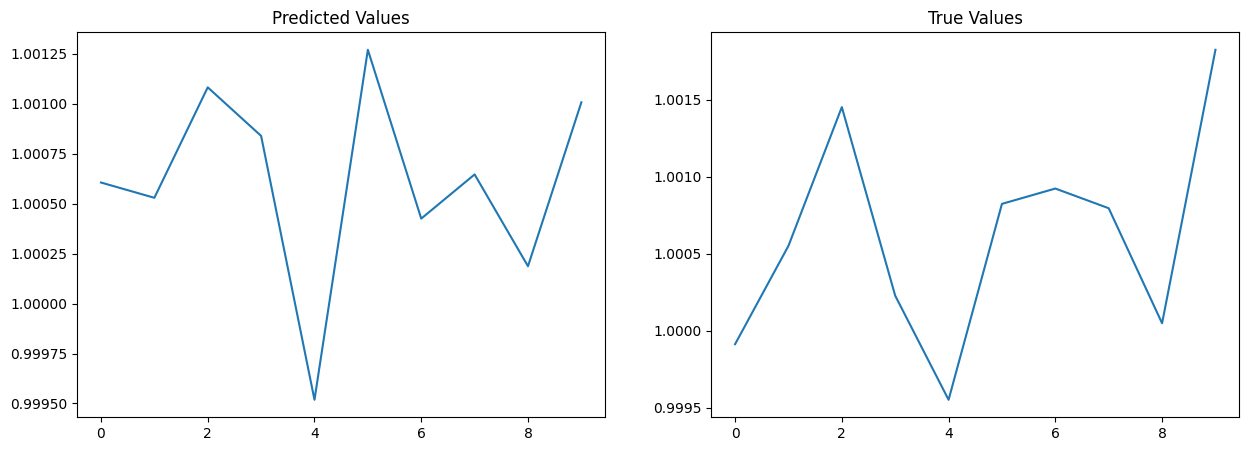

In [ ]:
pred = regressor.predict(predictors.drop(columns = "Date"))
true = df_yearly['Technology/AI'].reset_index().drop(columns='Date')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pred)
plt.title('Predicted Values')
plt.subplot(1, 2, 2)
plt.plot(true)
plt.title('True Values')
LR_MSE = np.mean((pred-true) ** 2)
print(f"MSE is {LR_MSE}")

We see that the MSE has decreased even lower than that of doing AR modelling on purely previous years' returns. While the prediction is still far from perfect, we see that it generally is more able to capture the general trend of the original returns. This seems to indicate that there is some effect to the previous returns of correlated industries .

# Conclusion

We find that using a linear regression model on the collective returns data of not just one industry, but a collective group of correlated industries, tend to provide somewhat interesting results. This is given that we aggregate the effect of noise impacting the prices of stocks over a short timeframe, by opting for a longer timeframe to model our data on.

However, it should also be noted that we cannot fully encapsulate the price of a stock just within the environment of a market. The price of a stock reflects a trader's confidence in its value, and this confidence is not only dependent on its quantitative features. There have been many cases of shock events that have significantly affected the prices of a stock. For example, Tesla's stock prices tend to fluctuate in response to its owner Elon Musk's statements, and we also see the heavy influence of COVID-19 on stock prices across a myriad of industries. 

On an industry level, however, we can see some level of predictability in our models. A huge component to this predictability is due to the fact that almost every industry will experience growth over the span of years. Furthermore, we cannot exclude the initial assumption that the errors from the models are white noise. It is possible that there are other variables that influence the movement of a stock's price, perhaps another closely correlated industry. In order to provide a more comprehensive insight into the exhaustive features that affect an industry's performance, more advanced data analysis techniques are required.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea8c3cf4-26f6-424c-9173-182c66c6521c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>